In [1]:
import os
import re
from pathlib import Path

import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem import *
from nltk.corpus import stopwords

from collections import Counter
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.exceptions import ConvergenceWarning
from sklearn.feature_selection import mutual_info_classif

import numpy as np
from scipy import stats
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  
import random
random.seed()
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [2]:
DATA_DIR = "20_newsgroups"

## Functions from lab

In [3]:
def clean_file_text(text):
    new_text = re.sub("Newsgroups:.*?\n", "", text)
    new_text = re.sub("Xref:.*?\n", "", new_text)
    new_text = re.sub("Path:.*?\n", "", new_text)
    new_text = re.sub("Date:.*?\n", "", new_text)
    new_text = re.sub("Followup-To:.*?\n", "", new_text)
    return new_text

In [4]:
def corpus_count_words(file_list):
    tokenizer = RegexpTokenizer(r'\w+')
    word_counter = Counter()
    for file_path in file_list:
        with open(file_path, 'r', encoding='utf-8', errors='ignore') as file:
            file_data = file.read()
            file_data = clean_file_text(file_data)
            file_words = tokenizer.tokenize(file_data)
            word_counter.update(file_words)
    return word_counter

In [5]:
def get_topic_name(file_path):
    return file_path.parent.name

def get_target(topic_name):
    topics = ['talk.politics.mideast', 'rec.autos', 'comp.sys.mac.hardware', 'alt.atheism', 'rec.sport.baseball', 
     'comp.os.ms-windows.misc', 'rec.sport.hockey', 'sci.crypt', 'sci.med', 'talk.politics.misc', 
     'rec.motorcycles', 'comp.windows.x', 'comp.graphics', 'comp.sys.ibm.pc.hardware', 'sci.electronics',
     'talk.politics.guns', 'sci.space', 'soc.religion.christian', 'misc.forsale', 'talk.religion.misc']
    return topics.index(topic_name)

In [6]:
def plot_confusion_matrix(cm):
    # plot the confusion matrix
    plt.figure(figsize=(10,10))
    plt.matshow(cm, fignum=1)
    
    # add labels for all targets
    num_targets = cm.shape[0]
    plt.xticks(list(range(num_targets+1)))
    plt.yticks(list(range(num_targets+1)))

## Q1

In [7]:
all_files = [pth for pth in Path(DATA_DIR).glob("**/*") if pth.is_file() and not pth.name.startswith(".")]

In [8]:
def binary_baseline_data(file_list, num_words = 1000):
    # Calculate word count in corpus
    news_cnt = corpus_count_words(file_list)
    
    # Select the most common numWords
    word_list = [word for (word, freq) in news_cnt.most_common(num_words)]
    
    # Create a binary encoding of dataset based on the selected features (X)
    tokenizer = RegexpTokenizer(r'\w+')
    df_rows = []
    for file_path in file_list:
        with open(file_path, 'r', encoding='utf-8', errors='ignore') as file:
            file_data = file.read()
            file_data = clean_file_text(file_data)
            file_words = tokenizer.tokenize(file_data)
            df_rows.append([1 if word in file_words else 0 for word in word_list])      
    X = pd.DataFrame(df_rows, columns = word_list)
    
    # Create a dataframe of targets (y)
    y = [get_target(get_topic_name(file_path)) for file_path in file_list]
    
    return X, y

In [9]:
# get the baseline data
X, y = binary_baseline_data(all_files)

# split to train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# train a logistic regression classifier
clf = LogisticRegression(C=1.0).fit(X_train, y_train)

# predict on train and test set
y_train_predict = clf.predict(X_train)
y_test_predict = clf.predict(X_test)

# calculate train and test accuracy
train_accuracy = accuracy_score(y_train, y_train_predict)
test_accuracy = accuracy_score(y_test, y_test_predict)

# report results
print("Train accuracy: {}".format(train_accuracy))
print("Test accuracy: {}".format(test_accuracy))

Train accuracy: 0.9146245624062299
Test accuracy: 0.6845


### Q1 (a)

[The feature set being used in this part is the top 1000 most common words in terms of frequency. If a certain file (row in the dataframe) contains the word, the corresponding binary value would be 1, and 0 otherwise. This dataset contains 19997 data samples (the total number of files). The hyper parameter is the regularizaton which is set to be 1,0, which is used to avoid overfitting.]

### Q1 (b)

Modify the following function:

In [10]:
# download required resources
nltk.download("wordnet")
nltk.download("stopwords")

[nltk_data] Downloading package wordnet to /Users/rong/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/rong/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Modify the corpus count function such to remove the stopwords such that the top 1000 words would be more meaningful.

In [11]:
def corpus_count_words_improved(file_list):
    tokenizer = RegexpTokenizer(r'\w+')
    word_counter = Counter()
    lemmatizer = WordNetLemmatizer() # lemmatization
    sw = stopwords.words('english') # list of stop words
    for file_path in file_list:
        with open(file_path, 'r', encoding='utf-8', errors='ignore') as file:
            file_data = file.read()
            file_data = clean_file_text(file_data)
            
            # lemmatize the file content before tokenization
            tokens = tokenizer.tokenize(lemmatizer.lemmatize(file_data))
            # remove stopwords from the tokens
            file_words = [word.lower() for word in tokens if word.lower() not in sw if len(word)>1 if word.isalpha()]
            
            word_counter.update(file_words)
    return word_counter

In [47]:
def binary_improved_data(file_list, num_words = 1000):
    # Calculate word count in corpus
    news_cnt = corpus_count_words_improved(file_list)
    
    # Select the most common numWords
    word_list = [word for (word, freq) in news_cnt.most_common(2*num_words)]
    
    # Create a binary encoding of dataset based on the selected features (X)
    tokenizer = RegexpTokenizer(r'\w+')
    lemmatizer = WordNetLemmatizer() # add a lemmatizer to the text
    sw = stopwords.words('english') # list of stop words
    
    df_rows = []
    for file_path in file_list:
        with open(file_path, 'r', encoding='utf-8', errors='ignore') as file:
            file_data = file.read()
            file_data = clean_file_text(file_data)
            
            # lemmatization before tokenization
            tokens = tokenizer.tokenize(lemmatizer.lemmatize(file_data))
            # remove stopwords, one letter tokens and numbers from tokens
            file_words = [word.lower() for word in tokens if word.lower() not in sw if len(word)>1 if word.isalpha()]
            
            df_rows.append([1 if word in file_words else 0 for word in word_list])      
    X = pd.DataFrame(df_rows, columns = word_list)
    X = X[X.columns[X.mean() < 0.05]].iloc[:,0:num_words]
    
    # Create a dataframe of targets (y)
    y = [get_target(get_topic_name(file_path)) for file_path in file_list]
    
    # validate return types
    assert isinstance(X, pd.DataFrame) and isinstance(y, list), "return types"
    
    return X, y

### Q1 (c)

Modify the following partial code to calculate the train and test accuracy and answer the question in the markdown cell below

In [48]:
# get the baseline data
X, y = binary_improved_data(all_files)

# Write your code here:
# You need to split the data and train a logistic regression classifier.
# Then, you need to calculate the variables train_accuracy and test_accuracy for the new classifier

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

clf = LogisticRegression(C=1.0).fit(X_train, y_train)

# predict on train and test set
y_train_predict = clf.predict(X_train)
y_test_predict = clf.predict(X_test)

train_accuracy = accuracy_score(y_train, y_train_predict)
test_accuracy = accuracy_score(y_test, y_test_predict)


# report results
print("Train accuracy: {}".format(train_accuracy))
print("Test accuracy: {}".format(test_accuracy))

Train accuracy: 0.9101950417946703
Test accuracy: 0.7465


[From the results above, we could obviously see that an improvment has achieved in prediction due to the increase in the accuracy score in both the train and test sets. This is due to the text processing of lemmatization and stopwords removal such that more meaningful words are being considered. Also, tokens with only one letter or a number are also removed since intuitively such tokens give less information to the classification problem.]

### Q1 (d)

Modify the partial code below

In [23]:
def random_mean_ci(X, y, num_tests):
    # train_results is a list of train accuracy results for the differrent random splits of the dataset
    train_results = []
    
    # test_results is a list of test accuracy results for the differrent random splits of the dataset
    test_results = []
    
    # Write your code here
    for i in range(num_tests):
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random.randint(1,1000))
        
        clf = LogisticRegression(C=1.0).fit(X_train, y_train)

        # predict on train and test set
        y_train_predict = clf.predict(X_train)
        y_test_predict = clf.predict(X_test)

        train_accuracy = accuracy_score(y_train, y_train_predict)
        test_accuracy = accuracy_score(y_test, y_test_predict)
        
        train_results.append(train_accuracy)
        test_results.append(test_accuracy)
    
    # calculate the train mean and the 95% confidence interval for the list of results
    train_mean = np.mean(train_results)
    train_ci_low, train_ci_high = stats.t.interval(0.95, len(train_results)-1, loc=train_mean, scale=stats.sem(train_results))
    
    # calculate the test mean and the 95% confidence interval for the list of results
    test_mean = np.mean(test_results)
    test_ci_low, test_ci_high = stats.t.interval(0.95, len(test_results)-1, loc=test_mean, scale=stats.sem(test_results))
    
    # validate return types
    assert isinstance(train_mean, float) and isinstance(train_ci_low, float) and isinstance(train_ci_high, float), "return types"
    assert isinstance(test_mean, float) and isinstance(test_ci_low, float) and isinstance(test_ci_high, float), "return types"
    
    return train_mean, train_ci_low, train_ci_high, test_mean, test_ci_low, test_ci_high

### Q1 (e)

Use the following code to calculate the mean accuracy and 95% confidence interval over 10 random splits

In [24]:
train_mean10, train_low10, train_high10, test_mean10, test_low10, test_high10 = random_mean_ci(X, y, num_tests = 10)
print("Train mean accuracy over 10 random splits: {}".format(train_mean10))
print("Train confidence interval over 10 random splits: [{}, {}]".format(train_low10, train_high10))
print("Test mean accuracy over 10 random splits: {}".format(test_mean10))
print("Test confidence interval over 10 random splits: [{}, {}]".format(test_low10, test_high10))

Train mean accuracy over 10 random splits: 0.9188683289276274
Train confidence interval over 10 random splits: [0.9177400390985191, 0.9199966187567357]
Test mean accuracy over 10 random splits: 0.7489833333333333
Test confidence interval over 10 random splits: [0.7460271818875758, 0.7519394847790909]


[We know from the confidence intervals that the perfomances of the model have small deviations or variances with different splits. This is much more imformative than a single trial as it gives us an idea of the variance of performance when classifiy small batches which is what real life would look like in production.]

### Q1 (f)

Modify the partial code below

In [25]:
def random_cm(X, y, num_tests):
    # cm_list is a list of confusion matrices for the different random splits of the dataset
    cm_list = []
    
    # Write your code here
    for i in range(0,num_tests):

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random.randint(1,1000))
        clf = LogisticRegression(C=1.0).fit(X_train, y_train)
        y_test_predict = clf.predict(X_test)
        cm = confusion_matrix(y_test, y_test_predict)
        cm_list.append(cm)
    
    # sum the confusion matrices and return the combined confusion matrix
    combined_cm = pd.Panel(cm_list).sum(axis=0)
    
    # validate return type
    assert isinstance(combined_cm, pd.DataFrame), "return type"
    
    return combined_cm

### Q1 (g)

Use the following code to produce a confusion matrix for 10 random splits

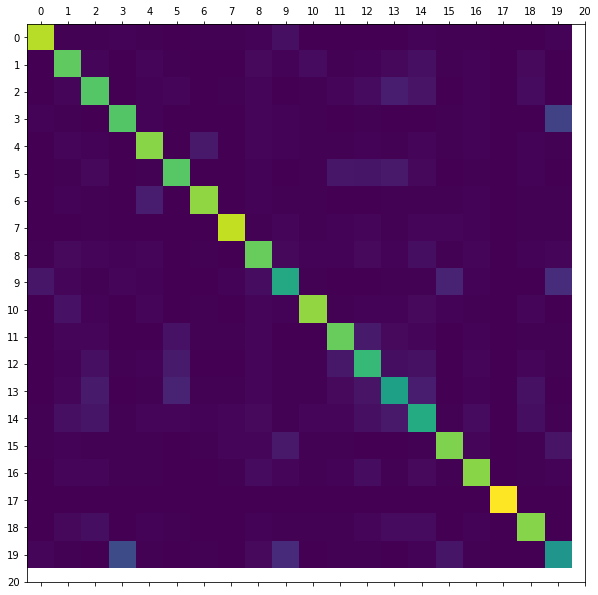

In [26]:
cm10 = random_cm(X, y, num_tests = 10)
plot_confusion_matrix(cm10)

In [27]:
pd.DataFrame(cm10)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,2623,19,15,34,16,1,12,12,26,118,1,1,9,7,27,16,14,0,2,32
1,6,2222,41,11,42,15,9,8,77,34,89,15,29,62,116,18,28,0,71,7
2,6,43,2166,5,30,54,10,19,45,9,19,54,92,224,156,10,24,0,81,10
3,31,15,6,2159,27,3,7,10,46,34,16,2,14,8,8,13,32,0,5,584
4,3,41,27,10,2415,10,201,9,47,25,17,15,29,21,41,12,24,0,34,16
5,0,14,58,9,13,2174,0,6,29,2,14,177,163,198,63,4,19,0,24,6
6,4,27,14,2,232,0,2460,2,26,12,13,9,11,17,19,16,26,0,16,13
7,2,9,17,8,11,11,1,2671,22,51,16,31,54,12,53,49,29,0,18,13
8,14,73,45,23,42,10,20,6,2264,59,30,30,78,33,110,19,45,0,25,38
9,173,36,14,35,24,9,8,24,96,1780,13,11,7,12,17,282,34,0,9,378


In [28]:
topics = ['talk.politics.mideast', 'rec.autos', 'comp.sys.mac.hardware', 'alt.atheism', 'rec.sport.baseball', 
 'comp.os.ms-windows.misc', 'rec.sport.hockey', 'sci.crypt', 'sci.med', 'talk.politics.misc', 
 'rec.motorcycles', 'comp.windows.x', 'comp.graphics', 'comp.sys.ibm.pc.hardware', 'sci.electronics',
 'talk.politics.guns', 'sci.space', 'soc.religion.christian', 'misc.forsale', 'talk.religion.misc']

In [29]:
confuses = [(topics[3],topics[19]),
            (topics[9],topics[15]),
            (topics[4],topics[6]),
            (topics[5],topics[13])]

In [30]:
confuses

[('alt.atheism', 'talk.religion.misc'),
 ('talk.politics.misc', 'talk.politics.guns'),
 ('rec.sport.baseball', 'rec.sport.hockey'),
 ('comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware')]

[The biggest confusion happened between topic 4 which is atheism and topic 20 which is religion, which makes sense since atheism is part of religion topics. Also, the model is confusing baseball with hockey since they are both team sports in North America. Subsets of guns and misc under politics topic are also confused since neither of them are obviously connected to politics.]

## Q2

### Q2 (a)

Modify the partial code below

In [31]:
def feature_num(X, y):
    # result_list is a list of tuples (num_features, train_accuracy, test_accuracy)
    # where numFeatures is the number of words used as features
    result_list = []
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    for p in [0.1, 0.2, 0.4, 0.6, 0.8, 1.0]:
        subset_size = int(p*X.shape[1])
        X_train_subset = X_train.iloc[:, 0:subset_size]
        X_test_subset = X_test.iloc[:, 0:subset_size]
        # Write your code here to calculate train_accuracy and test_accuracy for the current subset of features
        # ......
        clf = LogisticRegression(C=1.0).fit(X_train_subset, y_train)

        y_train_predict = clf.predict(X_train_subset)
        y_test_predict = clf.predict(X_test_subset)
        
        train_accuracy = accuracy_score(y_train, y_train_predict)
        test_accuracy = accuracy_score(y_test, y_test_predict)

        # add to result_list
        result_list.append((p, train_accuracy, test_accuracy))
        
    # Make a dataframe of the results
    result_df = pd.DataFrame(result_list, columns=["num_features", "train_accuracy", "test_accuracy"])
    
    # validate return type
    assert isinstance(result_df, pd.DataFrame), "return type"
    
    return result_df

### Q2 (b)

Use the following code to plot the train and test accuracy for the different feature sets sizes

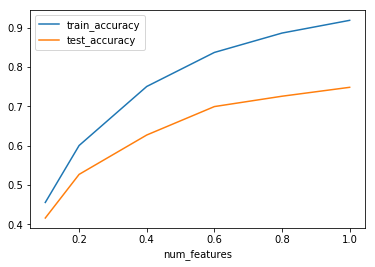

In [32]:
feature_num_df = feature_num(X, y)
feature_num_df.plot(x="num_features", y=["train_accuracy", "test_accuracy"])

[From the plot above, we could see that the perfomance (accuracy score) of the LR model improved with the number of features increasing.]

## Q3

### Q3 (a)

Modify the partial code below

In [33]:
def hyperparameter(X, y):
    # result_list is a list of tuples (num_features, train_accuracy, test_accuracy)
    # where numFeatures is the number of words used as features
    result_list = []
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    for param in [0.001, 0.01, 0.1, 1, 10, 100, 1000]:
        # Write your code here to calculate train_accuracy and test_accuracy for the current parameter value
        # ......
        clf = LogisticRegression(C=param).fit(X_train, y_train)

        y_train_predict = clf.predict(X_train)
        y_test_predict = clf.predict(X_test)
        
        train_accuracy = accuracy_score(y_train, y_train_predict)
        test_accuracy = accuracy_score(y_test, y_test_predict)
        
        # add to result_list
        result_list.append((param, train_accuracy, test_accuracy))
        
    # Make a dataframe of the results
    result_df = pd.DataFrame(result_list, columns=["param", "train_accuracy", "test_accuracy"])
    
    # validate return type
    assert isinstance(result_df, pd.DataFrame), "return type"
    
    return result_df

### Q3 (b)

Use the following code to plot the train and test accuracy for the different the parameters

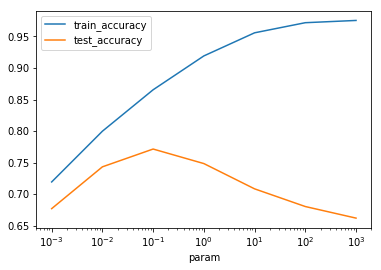

In [34]:
param_df = hyperparameter(X, y)
param_df.plot(x="param", y=["train_accuracy", "test_accuracy"], logx=True)

[From the plot above, we could see that the best performance on the test set happened with the hyperparameter C being 0.1. C<0.1 means not enough constraints on the model parameters resulting in underfitting, while adding to much constaint on the parameters (C>1) would lead to high vairance on the test set, implying overfitting.]

## Q4

### Q4 (a)

Modify the partial code below

In [41]:
def tf_improved_data(file_list, num_words = 1000):
    # Put your code here
    # Make sure you update the variable features and targets below
    
    # Calculate word count in corpus
#     news_cnt = corpus_count_words_improved(file_list)
    
    # Select the most common numWords
#     word_list = [word for (word, freq) in news_cnt.most_common(num_words)]
    
    # Create a binary encoding of dataset based on the selected features (X)
    tokenizer = RegexpTokenizer(r'\w+')
    lemmatizer = WordNetLemmatizer() # add a lemmatizer to the text
    sw = stopwords.words('english') # list of stop words
    
    df_rows = []
    X_org,y = binary_improved_data(file_list, num_words = 1000)
    col = X_org.columns.tolist()
    
    for file_path in file_list:
        with open(file_path, 'r', encoding='utf-8', errors='ignore') as file:
            file_data = file.read()
            file_data = clean_file_text(file_data)
            
            # lemmatization before tokenization
            tokens = tokenizer.tokenize(lemmatizer.lemmatize(file_data))
            # remove stopwords, one letter tokens and numbers from tokens
            file_words = [word.lower() for word in tokens if word.lower() not in sw if len(word)>1 if word.isalpha()]
            
            word_counter = Counter()
            word_counter.update(file_words)
            
            df_rows.append([word_counter[word] if word in file_words else 0 for word in col])      
    X = pd.DataFrame(df_rows, columns = col)
    
#     # Create a dataframe of targets (y)
#     y = [get_target(get_topic_name(file_path)) for file_path in file_list]
    

    # validate return types
    assert isinstance(X, pd.DataFrame) and isinstance(y, list), "return types"
    
    return X, y

### Q4 (b)

Use the following code to calculate the mean accuracy and 95% confidence interval over multiple random splits

In [42]:
X_tf, y_tf = tf_improved_data(all_files)
train_mean10, train_low10, train_high10, test_mean10, test_low10, test_high10 = random_mean_ci(X_tf, y_tf, num_tests = 10)
print("Train mean accuracy over 10 random splits: {}".format(train_mean10))
print("Train confidence interval over 10 random splits: [{}, {}]".format(train_low10, train_high10))
print("Test mean accuracy over 10 random splits: {}".format(test_mean10))
print("Test confidence interval over 10 random splits: [{}, {}]".format(test_low10, test_high10))

Train mean accuracy over 10 random splits: 0.9237265128241766
Train confidence interval over 10 random splits: [0.922644172957244, 0.9248088526911092]
Test mean accuracy over 10 random splits: 0.7243333333333333
Test confidence interval over 10 random splits: [0.7209709585801858, 0.7276957080864808]


[By comparing the results of the binary feature model and the tf feature model, we found that the tf model has a better performance with higher accuracy. Term frequency is a stronger indicator of a certain class than simply the occurrance of the word.]

## Q5

### Q5 (a)

Modify the partial code below

In [35]:
def nb_random_mean_ci(X, y, num_tests):
    # train_results is a list of train accuracy results for the differrent random splits of the dataset
    train_results = []
    
    # test_results is a list of test accuracy results for the differrent random splits of the dataset
    test_results = []
    
    # Write your code here
    for i in range(0,num_tests):
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random.randint(1,1000))
        
        clf = MultinomialNB().fit(X_train, y_train)

        # predict on train and test set
        y_train_predict = clf.predict(X_train)
        y_test_predict = clf.predict(X_test)

        train_accuracy = accuracy_score(y_train, y_train_predict)
        test_accuracy = accuracy_score(y_test, y_test_predict)
        
        train_results.append(train_accuracy)
        test_results.append(test_accuracy)
        
    # calculate the train mean and the 95% confidence interval for the list of results
    train_mean = np.mean(train_results)
    train_ci_low, train_ci_high = stats.t.interval(0.95, len(train_results)-1, loc=train_mean, scale=stats.sem(train_results))
    
    # calculate the test mean and the 95% confidence interval for the list of results
    test_mean = np.mean(test_results)
    test_ci_low, test_ci_high = stats.t.interval(0.95, len(test_results)-1, loc=test_mean, scale=stats.sem(test_results))
    
    # validate return types
    assert isinstance(train_mean, float) and isinstance(train_ci_low, float) and isinstance(train_ci_high, float), "return types"
    assert isinstance(test_mean, float) and isinstance(test_ci_low, float) and isinstance(test_ci_high, float), "return types"
    
    return train_mean, train_ci_low, train_ci_high, test_mean, test_ci_low, test_ci_high

### Q5 (b)

Use the following code to calculate the mean accuracy and 95% confidence interval over multiple random splits

In [36]:
train_mean10, train_low10, train_high10, test_mean10, test_low10, test_high10 = nb_random_mean_ci(X, y, num_tests = 10)
print("Train mean accuracy over 10 random splits: {}".format(train_mean10))
print("Train confidence interval over 10 random splits: [{}, {}]".format(train_low10, train_high10))
print("Test mean accuracy over 10 random splits: {}".format(test_mean10))
print("Test confidence interval over 10 random splits: [{}, {}]".format(test_low10, test_high10))

Train mean accuracy over 10 random splits: 0.7926484246624277
Train confidence interval over 10 random splits: [0.7914002457082709, 0.7938966036165844]
Test mean accuracy over 10 random splits: 0.7411833333333333
Test confidence interval over 10 random splits: [0.7393070623547199, 0.7430596043119467]


[It seems that NB model performs worse than the LR model, especially on the training set. This might be because Naive Bayes model assumes that all features are mutually independent with each other, however, this is very unlikely the case in our dataset.]

## Q6

In [37]:
def is_graduate_student():
    # ** Graduate students: change the return value to True **
    return True

### Q6 (a)

Modify the partial code below

In [38]:
def binary_med_data(file_list, num_words = 1000):
    # Put your code here
    # Make sure you update the variable features and targets below
    
    # Calculate word count in corpus
    news_cnt = corpus_count_words_improved(file_list)
    
    # Select the most common numWords
    word_list = [word for (word, freq) in news_cnt.most_common(num_words)]
    
    # Create a binary encoding of dataset based on the selected features (X)
    tokenizer = RegexpTokenizer(r'\w+')
    lemmatizer = WordNetLemmatizer() # add a lemmatizer to the text
    sw = stopwords.words('english') # list of stop words
    
    df_rows = []
    for file_path in file_list:
        with open(file_path, 'r', encoding='utf-8', errors='ignore') as file:
            file_data = file.read()
            file_data = clean_file_text(file_data)
            
            # lemmatization before tokenization
            tokens = tokenizer.tokenize(lemmatizer.lemmatize(file_data))
            # remove stopwords, one letter tokens and numbers from tokens
            file_words = [word.lower() for word in tokens if word.lower() not in sw if len(word)>1 if word.isalpha()]
            
            df_rows.append([1 if word in file_words else 0 for word in word_list])      
    X = pd.DataFrame(df_rows, columns = word_list)
    
    # Create a dataframe of targets (y)
    y = [1 if get_topic_name(file_path)=='sci.med' else 0 for file_path in file_list]
    
    
    # validate return types
    assert isinstance(X, pd.DataFrame) and isinstance(y, list), "return types"
    
    return X, y

### Q6 (b)

Use the following code to calculate the mean accuracy and 95% confidence interval over multiple random splits

In [36]:
X, y = binary_med_data(all_files)
train_mean10, train_low10, train_high10, test_mean10, test_low10, test_high10 = random_mean_ci(X, y, num_tests = 10)
print("Train mean accuracy over 10 random splits: {}".format(train_mean10))
print("Train confidence interval over 10 random splits: [{}, {}]".format(train_low10, train_high10))
print("Test mean accuracy over 10 random splits: {}".format(test_mean10))
print("Test confidence interval over 10 random splits: [{}, {}]".format(test_low10, test_high10))

Train mean accuracy over 10 random splits: 0.9886118453954419
Train confidence interval over 10 random splits: [0.9883327466961245, 0.9888909440947593]
Test mean accuracy over 10 random splits: 0.9732666666666667
Test confidence interval over 10 random splits: [0.9720261034308594, 0.9745072299024741]


[Obviously, we obtained a much better performance on both train and test set in this binary classfication compared with the multiclass classification problem in Q1. However, one obvious issue with this bianry classification is the class imbalance (1000 positive vs 18997 negative).]